# ReAct Agent Architecture

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()


from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list,add_messages]


In [3]:
from langchain_groq import  ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [4]:
from langchain_tavily import TavilySearch

searchTool=TavilySearch(max_results=2)
searchTool.invoke("What is LangGraph?")

{'query': 'What is LangGraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - IBM',
   'url': 'https://www.ibm.com/think/topics/langgraph',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling 

In [5]:
## custom function  -
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): First number.
        b (int): Second number.

    Returns:
        int: Product of a and b. (output int)
    """
    return a*b

In [6]:
tools=[searchTool,multiply]

llm_with_tool=llm.bind_tools(tools)

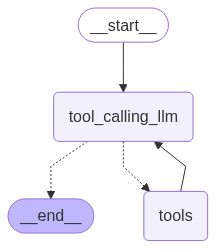

In [8]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
response=graph.invoke({"messages":"What are the recent ai news"})

In [10]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What are the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (jsszxz6qk)
 Call ID: jsszxz6qk
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.techtarget.com/searchenterpriseai/news/366626101/Apple-AI-paper-likely-self-serving-but-has-some-merit", "title": "Apple AI paper likely self-serving but has some merit - TechTarget", "score": 0.6241337, "published_date": "Tue, 17 Jun 2025 20:18:27 GMT", "content": "\"The ambition and the hope are warranted, but if these systems can't perform even on moderately complex tasks, then it's better to understand it relatively early

In [11]:
response=graph.invoke({"messages":"Give me the recent ai news and also multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and also multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (75b8dxrn0)
 Call ID: 75b8dxrn0
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
  multiply (ffy3ak6a5)
 Call ID: ffy3ak6a5
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4008912/wormgpt-returns-new-malicious-ai-variants-built-on-grok-and-mixtral-uncovered.html", "title": "WormGPT returns: New malicious AI variants built on Grok and Mixtral uncovered - csoonline.com", "score": 0.70214266, "published_date": "Wed, 18 Jun 2025 12:17:59 GMT", "content": "news ### New npm threats can erase production sys